# Counterfactual Fairness

This post introduces and replicates counterfactual fairness as proposed by Kusner et al. (2018) using DoWhy.

Counterfactual fairness serves as an individual-level measure of causal fairness, capturing the notion that an estimator's decision is deemed fair for an individual if it remains consistent both in (a) the actual world and (b) a counterfactual world where the individual is associated with a different demographic group.

### When to apply counterfactual fairness?
1. To assess whether a prediction is individually causally fair, i.e., if a prediction is fair for a given individual `i`.

### What is required to estimate counterfactual fairness?
1. Dataset with protected attributes or proxy variables.
2. A Structural Causal Model (SCM) : discovered either using a SCM discovery algorithm or through expert driven caual DAG creation.

##### Notation

- A: Set of protected attributes of an individual, representing variables that must not be subject to discrimination.
- a: Actual value taken by the protected attribute in the real world.
- a': Counterfactual (/flipped) value for the protected attribute.
- X: Other observable attributes of any particular individual.
- U: The set of relevant latent attributes that are not observed.
- Y: The outcome to be predicted, which might be contaminated with historical biases.
- $\hat{Y}$: The predictor, a random variable dependent on A, X, and U, produced by a machine learning algorithm as a prediction of Y.

Following Pearl, a structural causal model M is defined as a 4-tuple (U, V, F, P(u)), which can be represented using a directed acyclic graph (DAG) where:

- U: Set of exogenous (unobserved) variables determined by factors outside of the model.
- V: Set {V1 ... Vn} of endogenous (observed) variables completely determined by variables in the model (both U and V). Note: V includes both features X and output Y.
- F: Set of structural equations {f1 ... fn}, where each fi is a process by which Vi is assigned a value fi(v,u) in response to the current (relevant) values of U & V.
- P(u): (Prior) distribution over U.
- do(Zi = z): (Do) intervention (Pearl 2000, Ch. 3), representing a manipulation of M where the values of the chosen intervention variables Z (a subset of V) are set to a constant value z, regardless of how the values are ordinarily generated by the DAG. This captures the idea of an agent, external to the system, modifying the system by forcefully assigning value z to Zi (for example, as in a randomized experiment). In the fairness literature, Z often comprises protected attributes like race, gender, etc.

M is causal because given P(U), following a do intervention on a subset Z, we can derive the distribution over the remaining, non-intervened variables in V.


In [1]:
import warnings
from collections import namedtuple
from typing import Any, Callable, Dict, List, Tuple, Union
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator

import warnings
import dowhy
import matplotlib.pyplot as plt
import dowhy.gcm as gcm
import networkx as nx

from sklearn import datasets, metrics
from typing import List, Any, Union

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator


def analyse_counterfactual_fairness(
    df: pd.DataFrame,
    estimator: Union[BaseEstimator],
    protected_attrs: List[str],
    dag: List[Tuple],
    X: List[str],
    target: str,
    disadvantage_group: dict,
    intersectional: bool = False,
    return_cache: bool = False,
) -> Union[float, Tuple[float, pd.DataFrame, pd.DataFrame]]:
    """
    Calculates Counterfactual Fairness following Kusner et al. (2018)
    Reference - https://arxiv.org/pdf/1703.06856.pdf

    Args:
        df (pd.DataFrame): Pandas DataFrame containing non-factorized/dummified versions of categorical
            variables, the predicted ylabel, and other variables consumed by the predictive model.
        estimator (Union[BaseEstimator]): Predictive model to be used for generating the output.
        protected_attrs (List[str]): List of protected attributes in the dataset.
        dag (List[Tuple]): List of tuples representing the Directed Acyclic Graph (DAG) structure.
        X (List[str]): List of features to be used by the estimator.
        target (str): Name of the target variable in df.
        disadvantage_group (dict): Dictionary specifying the disadvantaged group for each protected attribute.
        intersectional (bool, optional): If True, considers intersectional fairness. Defaults to False.
        return_cache (bool, optional): If True, returns the counterfactual values with observed and
            counterfactual protected attribute interventions for each row in df. Defaults to False.

    Returns:
        counterfactual_fairness (Union[float, Tuple[float, pd.DataFrame, pd.DataFrame]]):
            - If return_cache is False, returns the calculated counterfactual fairness as a float.
            - If return_cache is True, returns a tuple containing counterfactual fairness as a float,
              DataFrame df_obs with observed counterfactual values, and DataFrame df_cf with perturbered counterfactual values.
    """

    invt_local_causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph(dag))
    gcm.auto.assign_causal_mechanisms(invt_local_causal_model, df)

    gcm.fit(invt_local_causal_model, df)

    df_cf = pd.DataFrame()
    df_obs = pd.DataFrame()

    do_val_observed = {protected_attr: "observed" for protected_attr in protected_attrs}
    do_val_counterfact = {protected_attr: "cf" for protected_attr in protected_attrs}

    for idx, row in df.iterrows():

        do_val_obs = {}
        for protected_attr, intervention_type in do_val_observed.items():
            intervention_val = float(
                row[protected_attr]
                if intervention_type == "observed"
                else 1 - float(row[protected_attr])
            )
            do_val_obs[protected_attr] = _wrapper_lambda_fn(intervention_val)

        do_val_cf = {}
        for protected_attr, intervention_type in do_val_counterfact.items():
            intervention_val = float(
                float(row[protected_attr])
                if intervention_type == "observed"
                else 1 - float(row[protected_attr])
            )
            do_val_cf[protected_attr] = _wrapper_lambda_fn(intervention_val)

        counterfactual_samples_obs = gcm.counterfactual_samples(
            invt_local_causal_model, do_val_obs, observed_data=pd.DataFrame(row).T
        )

        counterfactual_samples_cf = gcm.counterfactual_samples(
            invt_local_causal_model, do_val_cf, observed_data=pd.DataFrame(row).T
        )

        df_cf = pd.concat([df_cf, counterfactual_samples_cf])
        df_obs = pd.concat([df_obs, counterfactual_samples_obs])

    df_cf = df_cf.reset_index(drop=True)
    df_obs = df_obs.reset_index(drop=True)

    if hasattr(estimator, "predict_proba"):
        # 1. Samples from the causal model based on the observed race
        lr_observed = estimator()
        lr_observed.fit(df_obs[X].astype(float), df[target])
        df_obs[f"preds"] = lr_observed.predict_proba(df_obs[X].astype(float))[:, 1]

        # 2. Samples from the causal model based on the counterfactual race
        lr_cf = estimator()
        lr_cf.fit(df_cf[X].astype(float), df[target])
        df_cf[f"preds_cf"] = lr_cf.predict_proba(df_cf[X].astype(float))[:, 1]

    else:
        # 1. Samples from the causal model based on the observed race
        lr_observed = estimator()
        lr_observed.fit(df_obs[X].astype(float), df[target])
        df_obs[f"preds"] = lr_observed.predict(df_obs[X].astype(float))

        # 2. Samples from the causal model based on the counterfactual race
        lr_cf = estimator()
        lr_cf.fit(df_cf[X].astype(float), df[target])
        df_cf[f"preds_cf"] = lr_cf.predict(df_cf[X].astype(float))

    query = " and ".join(
        f"{protected_attr} == {disadvantage_group[protected_attr]}"
        for protected_attr in protected_attrs
    )
    mask = df.query(query).index.tolist()
    counterfactual_fairness = (
        df_obs.loc[mask]["preds"].mean() - df_cf.loc[mask]["preds_cf"].mean()
    )

    if not return_cache:
        return counterfactual_fairness
    else:
        return counterfactual_fairness, df_obs, df_cf

def plot_counterfactual_fairness(
    df_obs: pd.DataFrame,
    df_cf: pd.DataFrame,
    mask: pd.Series,
    counterfactual_fairness: Union[int, float],
    legend_observed: str,
    legend_counterfactual: str,
    target: str,
    title: str,
) -> None:
    """
    Plots counterfactual fairness comparing observed and counterfactual samples.

    Args:
        df_obs (pd.DataFrame): DataFrame containing observed samples.
        df_cf (pd.DataFrame): DataFrame containing counterfactual samples.
        mask (pd.Series): Boolean mask for selecting specific samples from the DataFrames.
        counterfactual_fairness (Union[int, float]): The counterfactual fairness metric.
        legend_observed (str): Legend label for the observed samples.
        legend_counterfactual (str): Legend label for the counterfactual samples.
        target (str): Name of the target variable to be plotted on the x-axis.
        title (str): Title of the plot.

    Returns:
        None: The function displays the plot.
    """

    fig, ax = plt.subplots(figsize=(8, 5), nrows=1, ncols=1)

    ax.hist(
        df_obs[f"preds"][mask], bins=50, alpha=0.7, label=legend_observed, color="blue"
    )
    ax.hist(
        df_cf[f"preds_cf"][mask], bins=50, alpha=0.7, label=legend_counterfactual, color="orange"
    )

    ax.set_xlabel(target)
    ax.legend()
    ax.set_title(title)

    fig.suptitle(f"Counterfactual Fairness {round(counterfactual_fairness, 3)}")

    plt.tight_layout()
    plt.show()


def _wrapper_lambda_fn(val):
    return lambda x: val

# 1. Load and Clean the Dataset

Kusner et al. (2018) use a survey, conducted by the Law School Admission Council, spanning 163 law schools in the United States, gathering data from 21,790 law students. The dataset used within this case study was originally collected for a study called ['LSAC National Longitudinal Bar Passage Study. LSAC Research Report Series'](https://eric.ed.gov/?id=ED469370) by Linda Wightman in 1998. The survey includes the following details:
- entrance exam scores (LSAT)
- pre-law school grade-point average (GPA)
- average grade in the first year (FYA).

It also includes protected attributes like:
- Race
- Sex

For the purpose of this example, we will focus on the difference in outcomes only between the White and Black sub-groups and limit the dataset to a random sample of 5000 individuals:

In [2]:
df = pd.read_csv("datasets/law_data.csv")

df["Gender"] = df["sex"].map({2: 0, 1: 1}).astype(str)
df["Race"] = df["race"].map({"White": 0, "Black": 1}).astype(str)

df = (
    df.query("race=='White' or race=='Black'")
    .rename(columns={"UGPA": "GPA", "LSAT": "LSAT", "ZFYA": "avg_grade"})[
        ["Race", "Gender", "GPA", "LSAT", "avg_grade"]
    ]
    .reset_index(drop=True)
)

df_sample = df.astype(float).sample(5000).reset_index(drop=True)

df_sample.head()

,Race,Gender,GPA,LSAT,avg_grade
0,0.0,0.0,2.7,35.0,-1.58
1,0.0,0.0,3.3,39.0,-0.20
2,0.0,0.0,3.2,40.0,0.94
3,1.0,1.0,3.3,32.0,-2.76
4,0.0,1.0,3.1,39.0,-0.98


Given this data, a school may wish to predict if an applicant will have a high FYA. The school would also like to make sure these predictions are not biased by an individual’s race and sex. However, the LSAT, GPA, and FYA scores, may be biased due to social factors. So how can we determine the degree to which such a predictie model may be biased for a particular individual? Using Counterfactual Fairness.

# 2. A Formal Definition of Counterfactual Fairness
 
Counterfactual fairness requires that, for each person in the population, the predicted value remain the same even if that person had different protected attributes in a causal sense. More formally, $\hat{Y}$ is counterfactually fair if under any context X = x and A = a:

$$P(\hat{Y}_{a}(U) = y | X = x, A = a) = P(\hat{Y}_{a'}(U) = y | X = x, A = a)$$

for all y and for any value a' attainable by A. This concept is closely connected to actual causes or token causality. In essence, for fairness, A should not be a direct cause of $\hat{Y}$ in any specific instance i.e. altering A while keeping non-causally dependent factors constant should not alter the distribution of $\hat{Y}$. For an individual i, the difference between Y generated from various counterfactual worlds can be understood as a measure of similarity.


### 2.1 Measuring Counterfactual Fairness

In a SCM M, the state of any observable variable (Vi) is fully determined by the background variables (U) and structural equations (F). Thus, given a fully-specified set of equations, using an SCM we can construct counterfactuals. That is

    "we can compute what (the distribution of) any of the variables would have been had certain other variables been different, other things being equal. For instance, given the causal model we can ask “Would individual i have graduated (Y = 1) if they hadn’t had a job?”, even if they did not actually graduate in the dataset." - (Russell et. al. , 2017)

Given a SCM M and evidence E (subset of V), counterfactuals are constructed (i.e. inferred) in three steps:

1. ***Abduction***: i.e. using M, adjusting noise variables to be consistent with the observed evidence E. More formally, given E and a prior distribution P(U),  compute the values of the set of unobserved variables U given M. For non-deterministic models (as is the case for most causal models in the literature), compute the posterior distribution P(U|E=e).

2. ***Action***: Perform do-intervention on Z (i.e. do(Zi = z)), resulting in the intervened SCM model M'.

3. ***Prediction***: Using the intervened model M' and P(U|E=e), compute the counterfactual value of V (or P(V |E=e)).


# 3. Measuring Counterfactual Fairness using DoWhy


Algorithmically, to empirically test whether a model is counterfactually fair:

- **Step 1 - Define a causal model** based on a causal DAG
- **Step 2 - Generate counterfactual samples**: Using ```gcm.counterfactual_samples``` , generate two sets of samples from the model:    
    a. one using the observed values of the protected attributes (`df_obs`)    
    b. one using counterfactual values of the protected attributes (`df_cf`)     
- **Step 3 - Fit estimators using sampled data**: Fit models to both the original and counterfactual sampled data and plot the distribution of the predicted target generated by the two models. *If the distributions overlap, the estimator is counterfactually fair else not.*

Given a dataset with protected / proxy attributes and a causal DAG , we can use the ```analyse_counterfactual_fairness``` function to measure counterfactual fairness at both the individual and aggregate level. In this example, we create the causal DAG based on the causal DAG provided in Kusner et al. (2018).

In [3]:
dag = [
    ("Race", "GPA"),
    ("Race", "LSAT"),
    ("Race", "avg_grade"),
    ("Gender", "GPA"),
    ("Gender", "LSAT"),
    ("Gender", "avg_grade"),
    ("GPA", "avg_grade"),
    ("LSAT", "avg_grade"),
]

The ```analyse_counterfactual_fairness``` method also accepts as inputs:
- the name of the target variable (`target` here avg_grade)
- the input dataset (`df`)
- an unfitted sklearn estimator (`estimator`; here LinearRegression)-
- list of protected attributes (`protected_attrs`)
- the list of input feature names (`X`)
- a dictionary specifying the unique identifying label of the disadvantaged group for each protected group (`disadvantage_group`). 

In [4]:
target = "avg_grade"
disadvantage_group = {"Race": 1}
protected_attrs = ["Race"]
features = ["GPA", "LSAT"]

### 3.1 Univariate Analysis

Now, we are ready to call the method ```analyse_counterfactual_fairness``` to carry out counterfactual fairness analysis along the Race dimension: 

In [5]:
config = {
    "df": df_sample,
    "dag": dag,
    "estimator": LinearRegression,
    "protected_attrs": protected_attrs,
    "X": features,
    "target": target,
    "disadvantage_group": disadvantage_group,
    "return_cache": True,
}

counterfactual_fairness, df_obs, df_cf = analyse_counterfactual_fairness(**config)
counterfactual_fairness

Fitting causal models:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Race:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node GPA:   0%|          | 0/5 [00:00<?, ?it/s] 

Fitting causal mechanism of node LSAT:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node avg_grade:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Gender:   0%|          | 0/5 [00:00<?, ?it/s]   

Fitting causal mechanism of node Gender: 100%|██████████| 5/5 [00:00<00:00, 226.88it/s]

`df_obs` contains the predicted values for each individual given the observed value of their protected attribute in the real world.

In [6]:
df_obs.head()

,Race,Gender,GPA,LSAT,avg_grade,preds
0,0.0,0.0,2.7,35.0,-1.58,-0.100578
1,0.0,0.0,3.3,39.0,-0.20,0.240501
2,0.0,0.0,3.2,40.0,0.94,0.255692
3,1.0,1.0,3.3,32.0,-2.76,-0.062055
4,0.0,1.0,3.1,39.0,-0.98,0.184438


`df_cf` contains the predicted values for each individual given the counterfactual value of their protected attribute in the real world. Here, since the only variable we are intervening on is Race, we see that each individual's Race has been changed from 0 to 1.

In [7]:
df_cf.head()

,Race,Gender,GPA,LSAT,avg_grade,preds_cf
0,1.0,0.0,2.288734,27.163129,-2.422552,0.065051
1,1.0,0.0,2.888734,31.163129,-1.341699,0.147126
2,1.0,0.0,2.788734,32.163129,-0.194623,0.151982
3,0.0,1.0,3.711266,39.836871,-1.581797,0.295120
4,1.0,1.0,2.688734,31.163129,-1.936561,0.134596


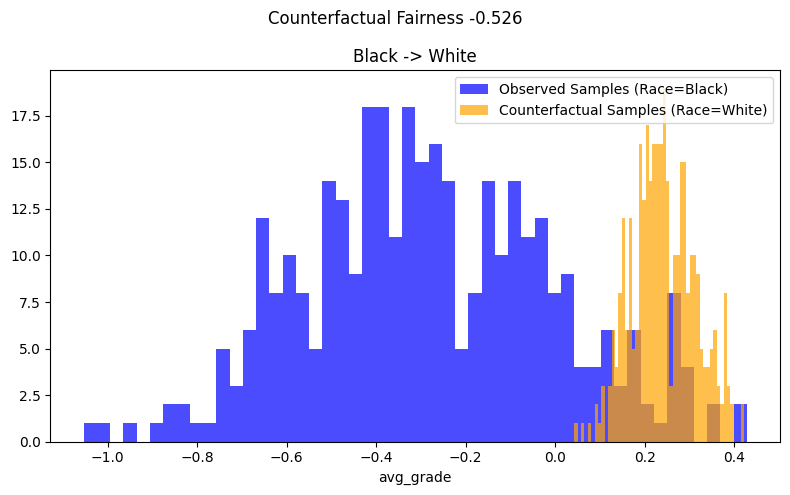

In [8]:
plot_counterfactual_fairness(
    df_obs=df_obs,
    df_cf=df_cf,
    mask=(df_sample["Race"] == 1).values,
    counterfactual_fairness=counterfactual_fairness,
    legend_observed="Observed Samples (Race=Black)",
    legend_counterfactual="Counterfactual Samples (Race=White)",
    target=target,
    title="Black -> White",
)

Examining the results for the example at hand in Figure 1, we see that the observed and counterfactual distributions don’t overlap. We see that changing the race of the black subgroup to the white subgroup shifts the distribution of $\hat{Y}$ to the right i.e. increases the avg_grade by ~0.50 on average. Thus, the fitted estimator can concluded to be not counterfactually fair.

### 3.2 Intersectional Analysis

We can further extend the analysis intersectionally, by examining the implication of multipleprotected attriutes on counterfactual fairness together. Here, we use the two protected attributes available to us - `["Race","Gender"]` - to carry out intersectional counterfactual fairness analysis to determine how counterfactually fair the estimator is for Black Females: 

In [9]:
disadvantage_group = {"Race": 1, "Gender": 1}
config = {
    "df": df_sample.astype(float).reset_index(drop=True),
    "estimator": LinearRegression,
    "protected_attrs": ["Race", "Gender"],
    "dag": dag,
    "X": features,
    "target": "avg_grade",
    "return_cache": True,
    "disadvantage_group": disadvantage_group,
    "intersectional": True,
}

counterfactual_fairness, df_obs, df_cf = analyse_counterfactual_fairness(**config)
counterfactual_fairness

Fitting causal models:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Race:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node GPA:   0%|          | 0/5 [00:00<?, ?it/s] 

Fitting causal mechanism of node LSAT:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node avg_grade:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Gender:   0%|          | 0/5 [00:00<?, ?it/s]   

Fitting causal mechanism of node Gender: 100%|██████████| 5/5 [00:00<00:00, 413.69it/s]

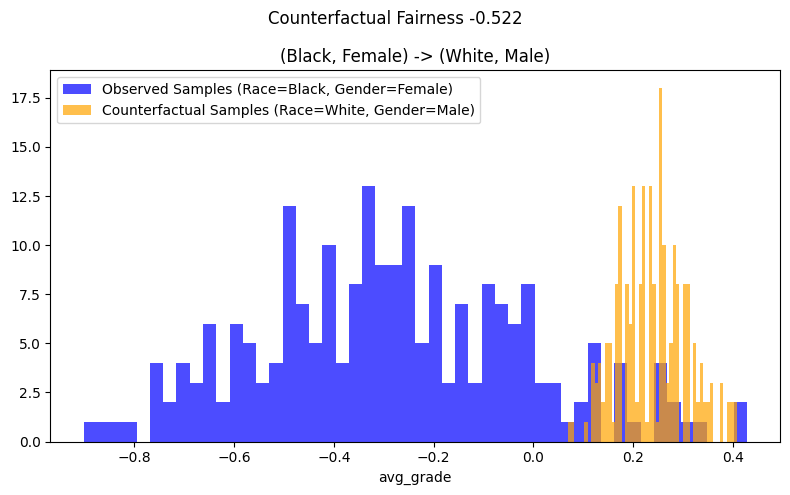

In [10]:
plot_counterfactual_fairness(
    df_obs=df_obs,
    df_cf=df_cf,
    mask=((df_sample["Race"] == 1).values & (df_sample["Gender"] == 1).values),
    counterfactual_fairness=counterfactual_fairness,
    legend_observed="Observed Samples (Race=Black, Gender=Female)",
    legend_counterfactual="Counterfactual Samples (Race=White, Gender=Male)",
    target=target,
    title="(Black, Female) -> (White, Male)",
)

Examining the results of the intersectional analysis in Figure 2, we see that the observed and counterfactual distributions don’t overlap at all. Changing the race and gender of the black females to the white males shifts the distribution of $\hat{Y}$ for the black,female sub-group to the right i.e. increases the avg_grade by ~0.50 on average. Thus, the fitted estimator can concluded to be not counterfactually fair intersectionally.

### 3.3 Some Additional Uses of the Counterfactuals `df_obs` , `df_cf` for Fairness

- Counterfactual values of Y (constructed using a set of fair causal models) can be used as a fair target to train the model with, in the presence of historically biased labels Y.
- Train an estimator to be counterfactually fair by using an optimization routine that applies a penalty for a given individual i in proportion to the (average) difference in Y across counterfactual worlds for that individual i. For instance, if for an individual i the outcome Y is very different across counterfactual worlds, then that sample i will increase the loss by a proportionately higher amount. Conversely, if for an individual j the outcome Y is similar across counterfactual worlds, then that sample i will increase the loss by a proportionately lower amount (See Russell, Chris et al., 2017 for more details).


# 4. Limitation of Counterfactual Fairness

There maybe disagreements about the "correct" causal model due to:

- Changing the structure of the DAG, e.g. adding an edge
- Changing the latent variables, e.g. changing the function generating a node to have a different signal vs. noise decomposition
- Preventing certain paths from propagating counterfactual values

The literature suggests achieving counterfactual fairness under multiple competing casual models as a solution to the above. Russell et. al. , (2017) put forward one such solution called the "Multi-World Fairness Algorithm".


# References

- Kusner, Matt et al. Counterfactual Fairness. 2018, https://arxiv.org/pdf/1703.06856.pdf
- Russell, Chris et al. When Worlds Collide: Integrating Different Counterfactual Assumptions In Fairness. 2017, https://proceedings.neurips.cc/paper/2017/file/1271a7029c9df08643b631b02cf9e116-Paper.pdf

# Appendix : Fairness Through Unawareness (FTU) creates A Counterfactually Unfair Estimator

To demonstrate that **"Aware" linear regression is always counterfactually fair but FTU makes it counterfactually unfair**, we build one "aware" linear regression and copare it with the "unaware" linear regression constructed Fig.1.

In [11]:
config = {
    "df": df_sample,
    "estimator": LinearRegression,
    "protected_attrs": ["Race"],
    "dag": dag,
    "X": ["GPA", "LSAT", "Race", "Gender"],
    "target": "avg_grade",
    "return_cache": True,
    "disadvantage_group": disadvantage_group,
}

counterfactual_fairness_aware, df_obs_aware, df_cf_aware = (
    analyse_counterfactual_fairness(**config)
)
counterfactual_fairness_aware

Fitting causal models:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Race:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node GPA:   0%|          | 0/5 [00:00<?, ?it/s] 

Fitting causal mechanism of node LSAT:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node avg_grade:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting causal mechanism of node Gender:   0%|          | 0/5 [00:00<?, ?it/s]   

Fitting causal mechanism of node Gender: 100%|██████████| 5/5 [00:00<00:00, 415.52it/s]

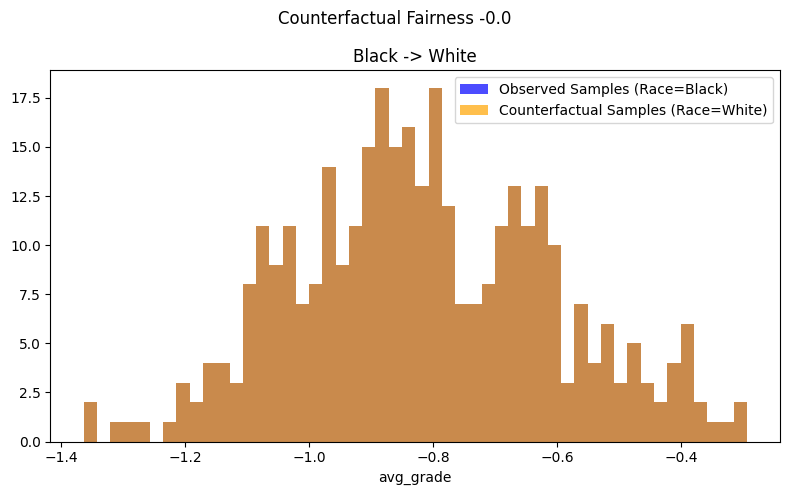

In [12]:
plot_counterfactual_fairness(
    df_obs=df_obs_aware,
    df_cf=df_cf_aware,
    mask=(df_sample["Race"] == 1).values,
    counterfactual_fairness=counterfactual_fairness_aware,
    legend_observed="Observed Samples (Race=Black)",
    legend_counterfactual="Counterfactual Samples (Race=White)",
    target=target,
    title="Black -> White",
)

Comparing Figure 1 and Figure 3, the comparitive plot of the observed counterfactual samples `df_obs` and perturbed counterfactual samples `df_cf`, shows that:

1. for the "aware" linear regression in figure 3, the two distributions overlap. Thus, the estimator is counterfactually fair.  
2. for the "unaware" linear regression in figure 1, the two distributions are quite distinct and do not overlap, suggesting that the estimator is counterfactually unfair i.e. regressing avg_grade on *only* GPA and LSAT makes the estimator counterfactually unfair.

Notable,it can formally be shown that, in general "Regressing Y on X alone obeys the FTU criterion but is not counterfactually fair, so omitting A (FTU) may introduce unfairness into an otherwise fair world". (Kusner et al. 2018)